In [ ]:
#cell 1
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=64, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        # This Conv2d layer performs the patching and the projection to embed_dim
        self.proj = nn.Conv2d(
            in_chans,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):
        # x shape: [Batch, 3, 64, 64]
        x = self.proj(x)  # [B, 768, 4, 4]
        x = x.flatten(2)  # [B, 768, 16]
        x = x.transpose(1, 2)  # [B, 16, 768]
        return x

In [ ]:
#cell 2
class ViTPrep(nn.Module):
    def __init__(self, n_patches=16, embed_dim=768):
        super().__init__()
        # Learnable CLS token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # Learnable Position Embeddings (n_patches + 1 for the CLS token)
        self.pos_embed = nn.Parameter(torch.zeros(1, n_patches + 1, embed_dim))

        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def forward(self, x):
        batch_size = x.shape[0]
        # Copy CLS token for every image in the batch
        cls_token = self.cls_token.expand(batch_size, -1, -1)
        # Attach CLS to the start of the sequence
        x = torch.cat((cls_token, x), dim=1)  # [B, 17, 768]
        # Add spatial location information
        x = x + self.pos_embed
        return x

In [ ]:
#cell 3
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=768, num_heads=8):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5

        # Combined linear layer for Query, Key, and Value
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, C = x.shape
        # Create Q, K, V and split them across heads
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Calculate Attention: (Q * K^T) / sqrt(d)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)

        # Apply attention to values and merge heads back
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x

In [ ]:
#cell 4
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU() # A smooth version of ReLU
        self.fc2 = nn.Linear(hidden_features, out_features)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=768, num_heads=8, mlp_ratio=4.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(
            in_features=embed_dim,
            hidden_features=int(embed_dim * mlp_ratio),
            out_features=embed_dim
        )

    def forward(self, x):
        # We add the result back to the input (Residual Connection)
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [ ]:
#cell 5
class VisionTransformer(nn.Module):
    def __init__(self, img_size=64, patch_size=16, in_chans=3, n_classes=10,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0):
        super().__init__()

        # 1. Image to Patches
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_chans, embed_dim)

        # 2. Add CLS Token and Position
        self.prep = ViTPrep(self.patch_embed.n_patches, embed_dim)

        # 3. Stack the Transformer Blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio)
            for _ in range(depth)
        ])

        # 4. Final classification layers
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, n_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.prep(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)

        # Only use the [CLS] token (index 0) for the final prediction
        logits = self.head(x[:, 0])
        return logits

In [ ]:
#cell 6
import torch
import torchvision
import torchvision.transforms as transforms
from google.colab import drive

# 1. Mount Drive for permanent storage
drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Define data processing (Resizing to 64x64 for speed)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 3. Load CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


In [ ]:
# Cell 7
import torch.optim as optim

# 1. Initialize Model
model = VisionTransformer(img_size=64, patch_size=16, n_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-1)

# 2. Training Loop
num_epochs = 5
print("Starting Training...")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Optimization steps
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f'Epoch {epoch+1} | Batch {i+1} | Loss: {running_loss / 100:.3f}')
            running_loss = 0.0

    # 3. Save to Google Drive
    save_path = f'/content/drive/MyDrive/vit_epoch_{epoch+1}.pth'
    torch.save(model.state_dict(), save_path)
    print(f"✅ Epoch {epoch+1} saved to: {save_path}")

print("Training Finished!")

Starting Training...
Epoch 1 | Batch 100 | Loss: 2.197
Epoch 1 | Batch 200 | Loss: 1.987
Epoch 1 | Batch 300 | Loss: 1.929
Epoch 1 | Batch 400 | Loss: 1.885
Epoch 1 | Batch 500 | Loss: 1.864
Epoch 1 | Batch 600 | Loss: 1.821
Epoch 1 | Batch 700 | Loss: 1.822
✅ Epoch 1 saved to: /content/drive/MyDrive/vit_epoch_1.pth
Epoch 2 | Batch 100 | Loss: 1.784
Epoch 2 | Batch 200 | Loss: 1.759
Epoch 2 | Batch 300 | Loss: 1.758
Epoch 2 | Batch 400 | Loss: 1.753
Epoch 2 | Batch 500 | Loss: 1.730
Epoch 2 | Batch 600 | Loss: 1.758
Epoch 2 | Batch 700 | Loss: 1.737
✅ Epoch 2 saved to: /content/drive/MyDrive/vit_epoch_2.pth
Epoch 3 | Batch 100 | Loss: 1.746
Epoch 3 | Batch 200 | Loss: 1.749
Epoch 3 | Batch 300 | Loss: 1.718
Epoch 3 | Batch 400 | Loss: 1.698
Epoch 3 | Batch 500 | Loss: 1.695
Epoch 3 | Batch 600 | Loss: 1.694
Epoch 3 | Batch 700 | Loss: 1.672
✅ Epoch 3 saved to: /content/drive/MyDrive/vit_epoch_3.pth
Epoch 4 | Batch 100 | Loss: 1.695
Epoch 4 | Batch 200 | Loss: 1.691
Epoch 4 | Batch 300 

In [ ]:
#cell 7.1
# Use this cell to load your model after a disconnect

# 1. Initialize the skeleton (same settings as before)
model = VisionTransformer(img_size=64, patch_size=16, n_classes=10).to(device)

# 2. Path to your finished epoch (adjust name if needed)
load_path = '/content/drive/MyDrive/vit_epoch_5.pth'

# 3. Load the weights
checkpoint = torch.load(load_path, map_location=device)
model.load_state_dict(checkpoint)

print(f"✅ Model successfully loaded from {load_path}")
print("You can now proceed to #cell 8.")

✅ Model successfully loaded from /content/drive/MyDrive/vit_epoch_5.pth
You can now proceed to #cell 8.


In [ ]:
#cell 8
from sklearn.metrics import classification_report, confusion_matrix
import torch
import numpy as np

def run_evaluation(model, loader):
    model.eval() # Switches the model to 'test mode'
    all_preds = []
    all_labels = []

    print("🚀 Starting inference on 10,000 test images...")
    with torch.no_grad(): # Saves memory by not calculating gradients
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1) # Gets the class with the highest probability

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

# Execute Evaluation
y_true, y_pred = run_evaluation(model, testloader)

# Output Results
print("\n" + "="*45)
print("VISION TRANSFORMER (ViT) PERFORMANCE REPORT")
print("="*45)
print(classification_report(y_true, y_pred, target_names=classes))

🚀 Starting inference on 10,000 test images...

VISION TRANSFORMER (ViT) PERFORMANCE REPORT
              precision    recall  f1-score   support

       plane       0.51      0.46      0.48      1000
         car       0.44      0.52      0.47      1000
        bird       0.32      0.24      0.28      1000
         cat       0.27      0.37      0.31      1000
        deer       0.36      0.41      0.38      1000
         dog       0.37      0.24      0.29      1000
        frog       0.47      0.27      0.34      1000
       horse       0.45      0.36      0.40      1000
        ship       0.45      0.65      0.53      1000
       truck       0.41      0.47      0.44      1000

    accuracy                           0.40     10000
   macro avg       0.40      0.40      0.39     10000
weighted avg       0.40      0.40      0.39     10000



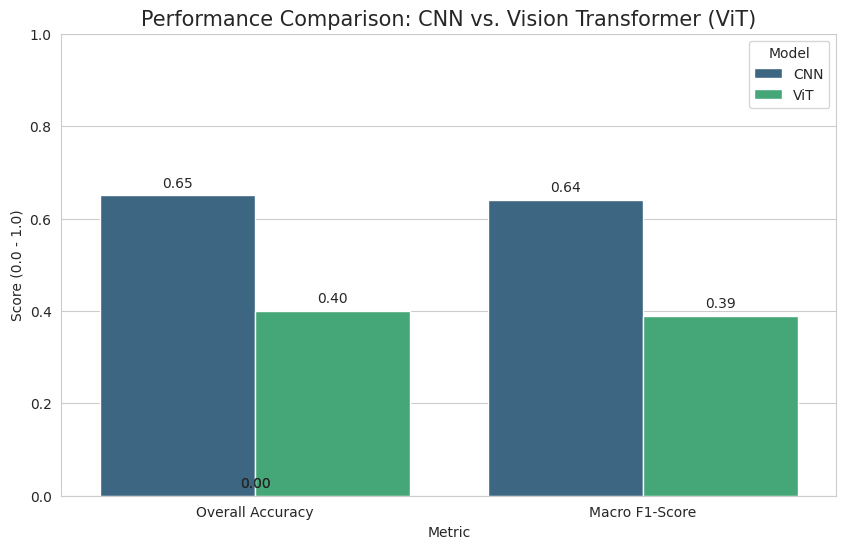

In [ ]:
#cell 9
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# --- ACTION REQUIRED: ENTER YOUR CNN RESULTS HERE ---
# Replace these placeholder numbers with your actual CNN results
cnn_accuracy = 0.65  # Example: 65%
cnn_macro_f1 = 0.64  # Example: 64%

# ViT results from your #cell 8 output
vit_accuracy = 0.40
vit_macro_f1 = 0.39

# Data Preparation
data = {
    'Model': ['CNN', 'ViT', 'CNN', 'ViT'],
    'Metric': ['Overall Accuracy', 'Overall Accuracy', 'Macro F1-Score', 'Macro F1-Score'],
    'Score': [cnn_accuracy, vit_accuracy, cnn_macro_f1, vit_macro_f1]
}

df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x='Metric', y='Score', hue='Model', data=df, palette='viridis')

# Adding labels and title
plt.title('Performance Comparison: CNN vs. Vision Transformer (ViT)', fontsize=15)
plt.ylim(0, 1.0)
plt.ylabel('Score (0.0 - 1.0)')

# Adding the percentage text on top of bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.show()